In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple
from scipy.interpolate import RBFInterpolator
from matplotlib import path
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.tri as tri
from scipy.spatial import distance
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Utility functions
n_grid_x = 100
n_grid_y = 100


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, n_grid_x)
    y_vec = np.linspace(38, 52, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid


In [4]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-02 00:18:36.380 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-02 00:18:36.380 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-02-00-18-36
2022-09-02 00:18:36.381 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-02-00-18-36/2022-09-02-00-18-36.log
2022-09-02 00:18:36.381 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-02 00:18:36.386 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-02 00:18:36.388 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-02 00:18:36.388 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-02 00:18:36.416 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-02 00:18:36.420 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-02 00:18:36.421 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-02 00:18:36.422 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


In [5]:
# This is LeVeque's code and there's something special about
# the strike and dip distances that I don't understand

earth_radius = 6.371e6  # radius of earth

# approximate conversion factor from degrees latitude to meters
lat2meter = np.deg2rad(earth_radius)

distance_matrix = np.zeros((meshes[0].n_tde, meshes[0].n_tde))
distance_matrix_strike = np.zeros((meshes[0].n_tde, meshes[0].n_tde))
distance_matrix_dip = np.zeros((meshes[0].n_tde, meshes[0].n_tde))
for i in range(meshes[0].n_tde):
    xi = meshes[0].centroids[i, 0]
    yi = meshes[0].centroids[i, 1]
    zi = meshes[0].centroids[i, 2]
    for j in range(meshes[0].n_tde):
        xj = meshes[0].centroids[j, 0]
        yj = meshes[0].centroids[j, 1]
        zj = meshes[0].centroids[j, 2]
        dx = abs(xi - xj) * np.cos(np.deg2rad(0.5 * (yi + yj))) * lat2meter
        dy = abs(yi - yj) * lat2meter
        dz = abs(zi - zj)

        # Euclidean distance
        distance_matrix[i, j] = np.sqrt(dx**2.0 + dy**2.0 + dz**2.0)

        # Estimate distance down-dip based on depths
        # average_dip = 0.5 * (meshes[0].dip[i] + meshes[0].dip[j])
        # ddip1 = dz / np.sin(np.deg2rad(average_dip))
        # distance_matrix_dip[i, j] = ddip1
        distance_matrix_dip[i, j] = dz / np.sin(
            np.deg2rad(0.5 * (meshes[0].dip[i] + meshes[0].dip[j]))
        )

        # Compute distance in strike direction to sum up properly
        distance_matrix_strike[i, j] = np.sqrt(
            max(distance_matrix[i, j] ** 2.0 - distance_matrix_dip[i, j] ** 2.0, 0.0)
        )


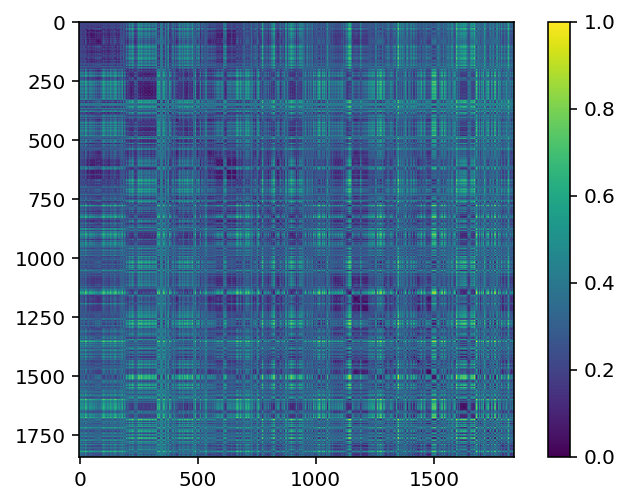

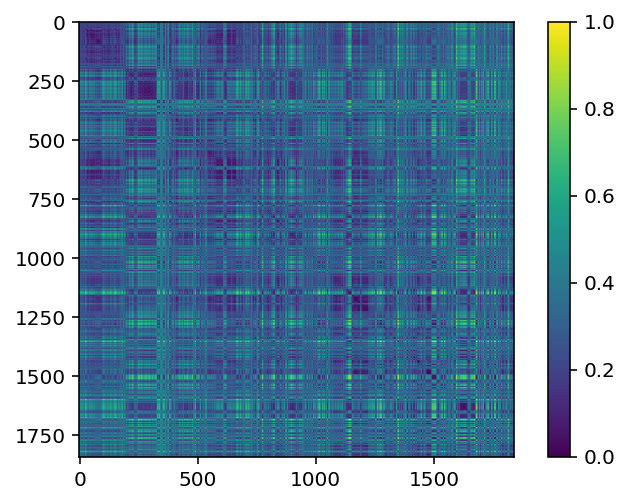

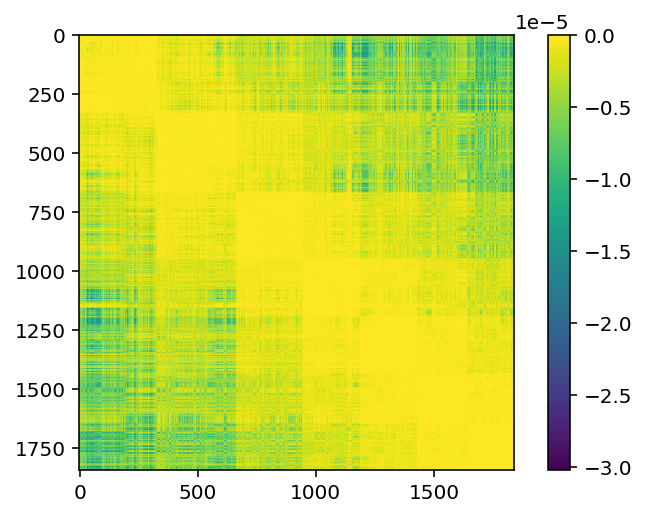

In [6]:
# Build correlation matrix
correlation_length_scale_strike = 400e3
correlation_length_scale_dip = 40e3

scaled_distance_matrix = np.sqrt(
    (distance_matrix_strike / correlation_length_scale_strike) ** 2.0
    + (distance_matrix_dip / correlation_length_scale_dip) ** 2.0
)
correlation_matrix = np.exp(-scaled_distance_matrix)

distance_matrix = distance_matrix - np.min(distance_matrix)
distance_matrix = distance_matrix / np.max(distance_matrix)

correlation_matrix = np.exp(-distance_matrix)


# Get magnitude sorted eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
ordered_index = np.flip(np.argsort(eigenvalues))
eigenvalues = eigenvalues[ordered_index]
eigenvectors = eigenvectors[:, ordered_index]

# Temporarly rescaling tests
distance_matrix = distance_matrix - np.min(distance_matrix)
distance_matrix = distance_matrix / np.max(distance_matrix)

scaled_distance_matrix = scaled_distance_matrix - np.min(scaled_distance_matrix)
scaled_distance_matrix = scaled_distance_matrix / np.max(scaled_distance_matrix)


plt.figure()
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(scaled_distance_matrix)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(distance_matrix - scaled_distance_matrix)
plt.colorbar()
plt.show()



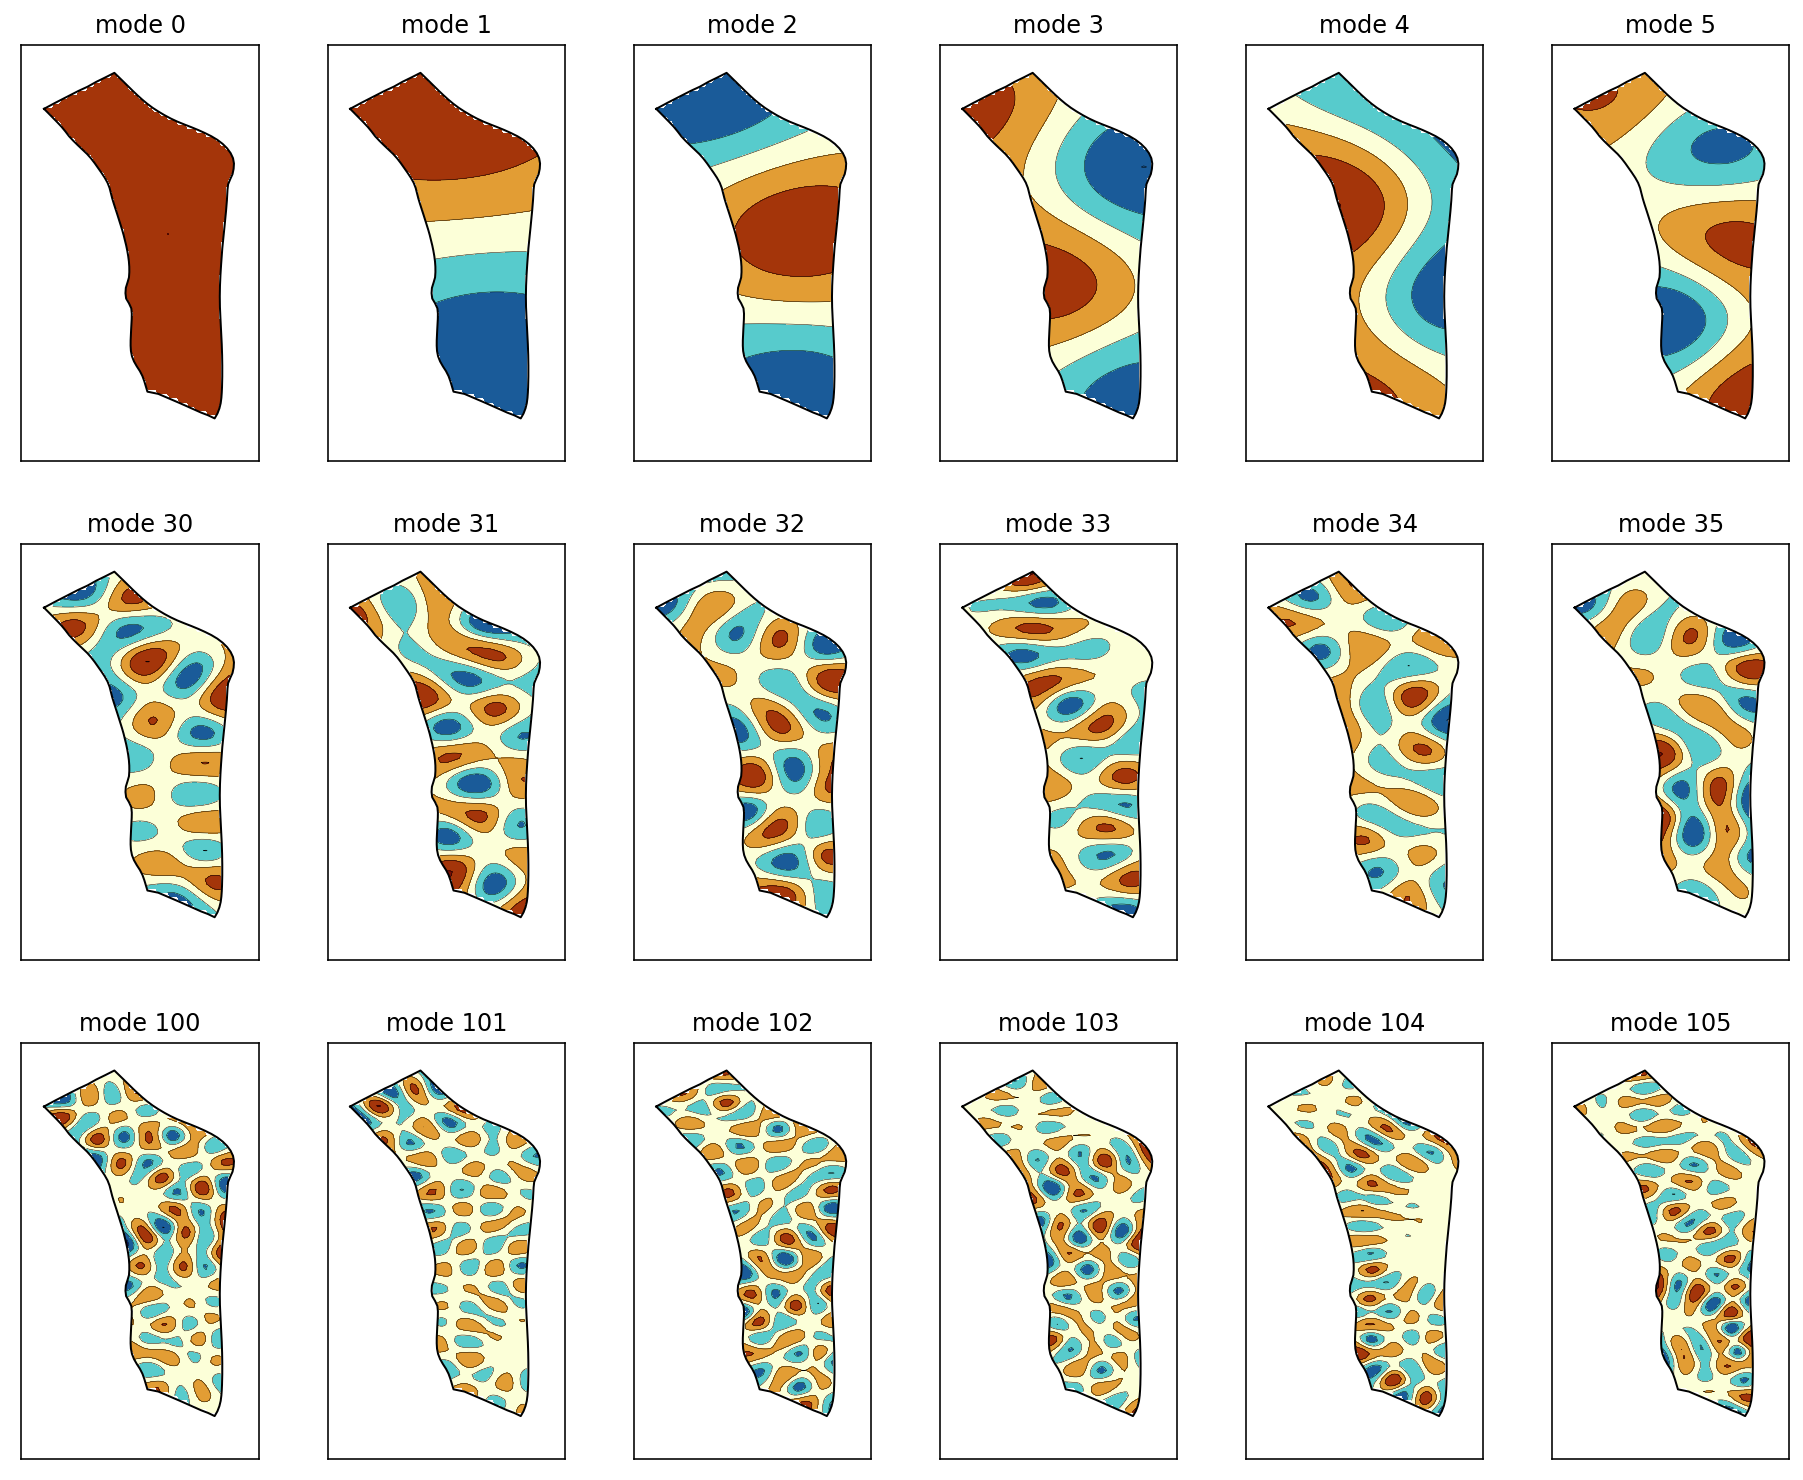

In [7]:
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, 6)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


# Plot select eigenmodes
plt.figure(figsize=(16, 13))
cmap = make_cmap.make_cmap("w_ymiddle1.xml")
# cmap = cmap.reversed()
for i in range(0, 18):
    ax = plt.subplot(3, 6, i + 1)

    # Shift eigenmodes by plotting row to show some dynamic range
    if i > 5 and i <= 11:
        i = i - 6 + 30
    elif i > 11:
        i = i - 12 + 100
    fill_value = fill_value = eigenvectors[:, i]

    # Normalize fill_value for interpretable plotting
    min_value = np.min(fill_value)
    max_value = np.max(fill_value)
    if np.abs(max_value) > np.abs(min_value):
        fill_value = fill_value / max_value
    else:
        fill_value = fill_value / np.abs(min_value)

    if i == 0 and np.nanmean(fill_value) < 0:
        fill_value = -1 * fill_value

    interpolate_and_plot(fill_value)
    plt.title(f"mode {i}")

plt.savefig("select_eigenmodes.pdf")
plt.savefig("select_eigenmodes.png", dpi=500)
plt.show()


In [8]:
def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


# def plot_slip_distributions(
#     mesh, slip_distribution_input, slip_distribution_estimated, suptitle_string
# ):


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


In [9]:
# operators = addict.Dict()
tde_matrix = celeri.get_tde_to_velocities(meshes, station, command)
# celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
# tde_matrix = copy.deepcopy(operators.tri_station)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

# Generate synthetic slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(
    meshes[0], tde_matrix
)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]


Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:16<00:00, 108.46it/s]


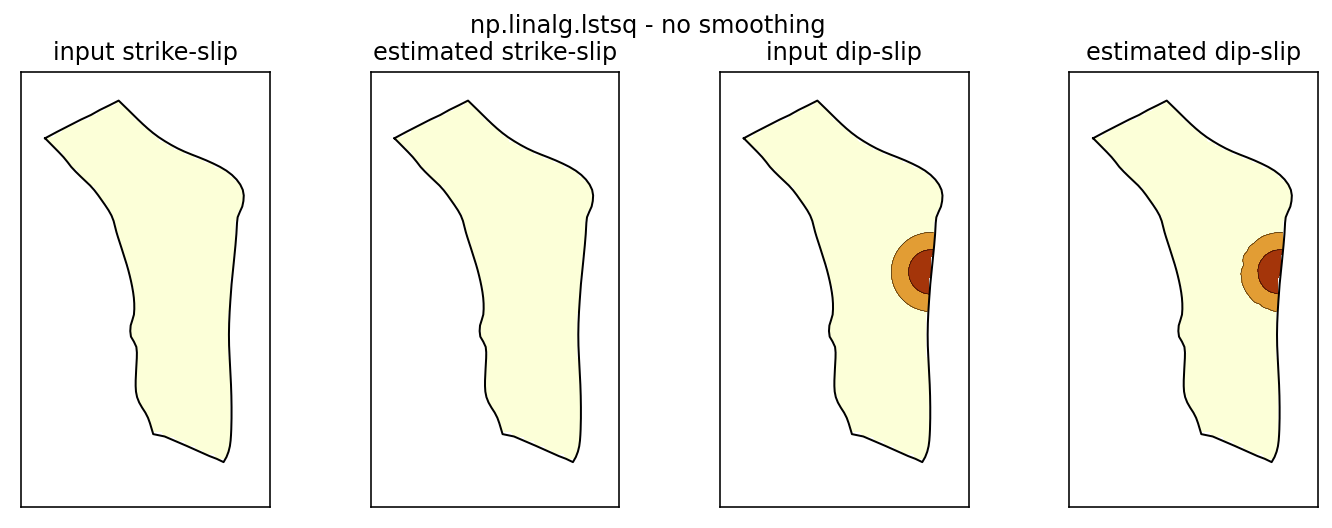

In [10]:
# Direct least squares estimate with no smoothing
slip_distribution_estimated = np.linalg.lstsq(
    tde_matrix, synthetic_displacements, rcond=None
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution_estimated[0],
    suptitle_string="np.linalg.lstsq - no smoothing",
)


eigenvectors.shape=(1841, 1841)
eigenvectors_small.shape=(1841, 100)
tde_matrix.shape=(3372, 3682)
tde_matrix_dip_only.shape=(3372, 1841)


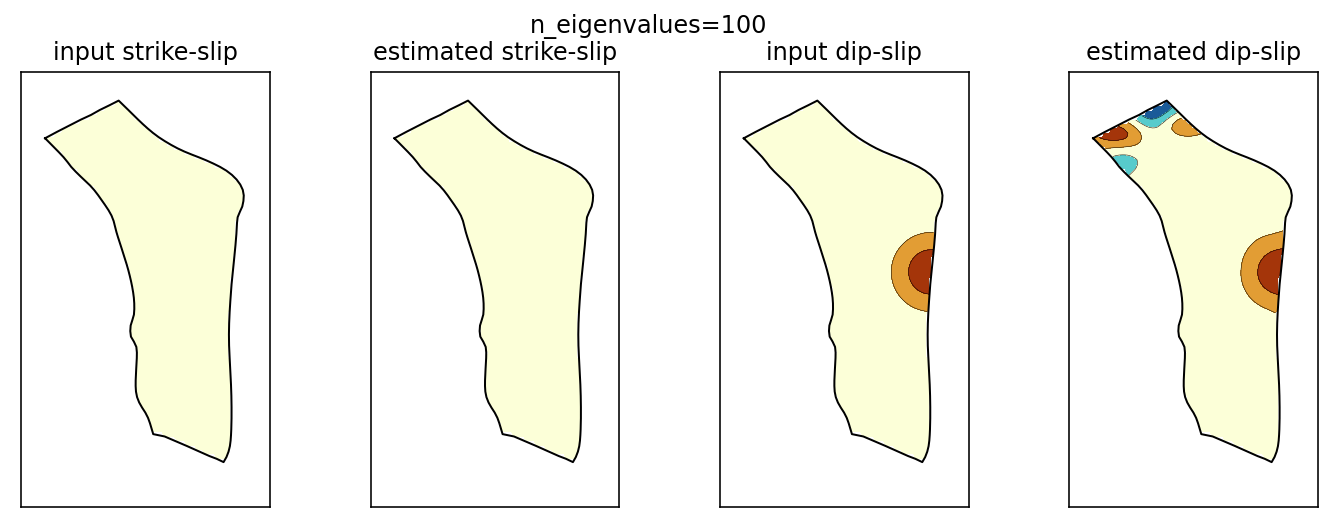

In [11]:
# Eigenvalue slip estimate with dip slip only
n_eigenvalues = 100

# Select subset of eigenvalues/vectors
eigenvectors_small = eigenvectors[:, 0:n_eigenvalues]

# Select dip-slip only
tde_matrix_dip_only = tde_matrix[:, 1::2]

print(f"{eigenvectors.shape=}")
print(f"{eigenvectors_small.shape=}")
print(f"{tde_matrix.shape=}")
print(f"{tde_matrix_dip_only.shape=}")

# Solve for eigenvector weights
eigenvector_weights_estimated = (
    np.linalg.pinv(tde_matrix_dip_only @ eigenvectors_small) @ synthetic_displacements
)

# Recover slip from eigenvector weights
slip_distribution_estimated_eigs = (
    eigenvectors_small @ eigenvector_weights_estimated
)

# Select dip slip only
slip_distribution_eigs = np.zeros(2 * eigenvectors.shape[0])
slip_distribution_eigs[1::2] = slip_distribution_estimated_eigs

plot_slip_distributions(
    slip_distribution,
    slip_distribution_eigs,
    suptitle_string=f"{n_eigenvalues=}",
)

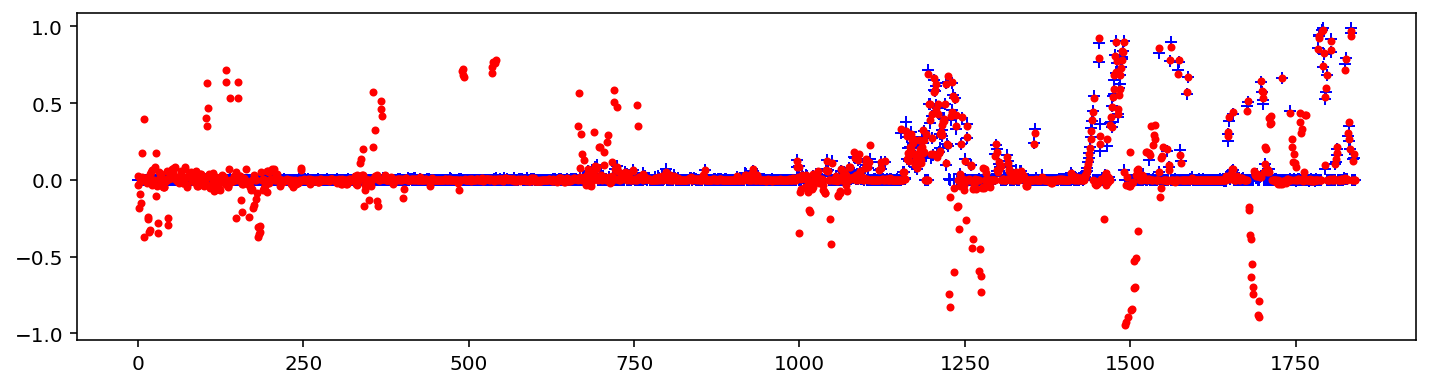

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(slip_distribution_estimated[0][1::2], "b+")
plt.plot(slip_distribution_eigs[1::2], "r.")
plt.show()


In [13]:
# a1, b1 = np.linalg.eig(C)

# # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
# n_eigenvalues = meshes[0].n_tde
# # n_eigenvalues = 200

# eigenvalues, eigenvectors = scipy.linalg.eigh(
#     C, subset_by_index=[meshes[0].n_tde - n_eigenvalues, meshes[0].n_tde - 1]
# )
# np.sort(eigenvalues)

In [14]:
# plt.figure()
# plt.plot(np.sort(a1), "b+")
# plt.plot(np.sort(eigenvalues), "r.")
# plt.show()

# plt.figure()
# # plt.plot(np.sort(a1), "b+")
# plt.plot(np.sort(eigenvalues) - np.sort(a1), "r.")
# plt.show()

In [25]:
coords = [(35.0456, -85.2672),
          (35.1174, -89.9711),
          (35.9728, -83.9422),
          (36.1667, -86.7833)]
coords = np.array(coords)
print(coords.shape)
centroid_coordinates = np.array([meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].y_centroid]).T
print(centroid_coordinates.shape)
# distance.cdist(coords, coords, 'euclidean')
cdistance_matrix = distance.cdist(centroid_coordinates, centroid_coordinates, "euclidean")


(4, 2)
(1841, 3)


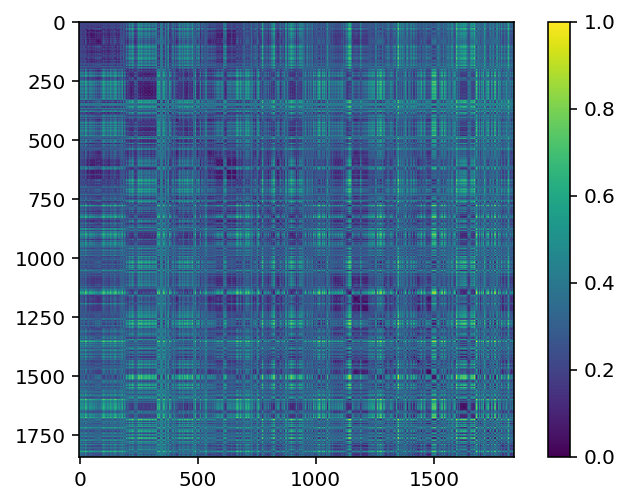

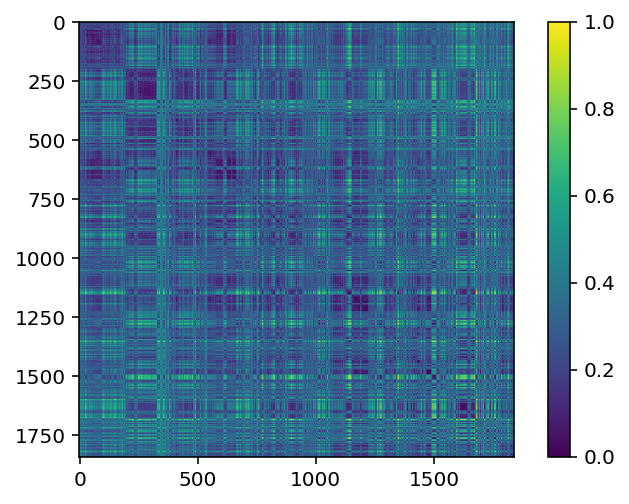

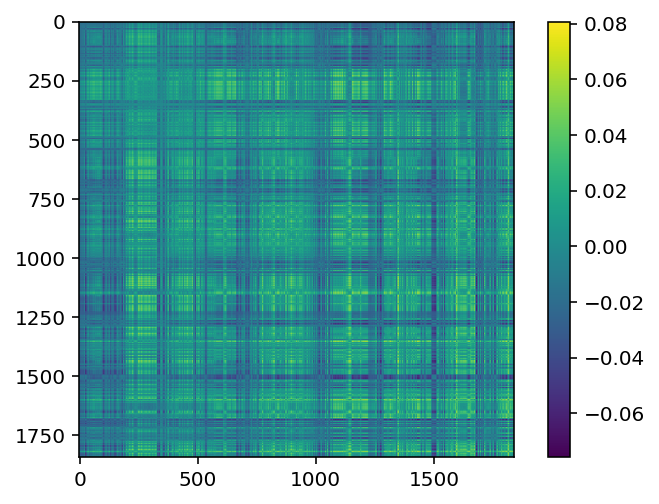

In [26]:
cdistance_matrix = cdistance_matrix - np.min(cdistance_matrix)
cdistance_matrix = cdistance_matrix / np.max(cdistance_matrix)


plt.figure()
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(cdistance_matrix)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(distance_matrix - cdistance_matrix)
plt.colorbar()
plt.show()
